In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



## Some background reading

###### Space Weather:
- [Introduction](https://ccmc.gsfc.nasa.gov/RoR_WWW/SWREDI/2016/SpaceWeatherIntro_Bootcamp_2016.pdf)
- [Understanding space weather](https://www.sciencedirect.com/science/article/pii/S0273117715002252)

###### Particle Precipitation:
Here are a few particle precipitation resources that I believe are most valuable to start with:
- Technical details of the observations: [Redmon et al., [2017]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JA023339)
- Creating particle precipitation models from these data: [Hardy et al., [1987]](https://doi.org/10.1029/JA090iA05p04229) and [Newell et al., [2009]](https://doi.org/10.1029/2009JA014326)
- Considered the 'state of the art' model: [OVATION PRIME](https://ccmc.gsfc.nasa.gov/models/modelinfo.php?model=Ovation%20Prime)



## Imports and utility functions


In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

from sklearn import *

## Prepare data for ML exploration (read in full DB created from standard_ML_DB_preparation.ipynb)


In [4]:
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)


In [5]:
df_cumulative.shape



(1947016, 149)

In [5]:
# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]
print( (feature_cols))
print(df_cumulative.columns)

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
print(numFeatures)

validation data shape = (55210, 149)
train data shape = (1838283, 149)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here
['SC_AACGM_LAT', 'ID_SC', 'sin_ut', 'cos_ut', 'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME', 'F107', 'Bz', 'By', 'Bx', 'AE', 'AL', 'AU', 'SymH', 'PC', 'vsw', 'vx', 'psw', 'borovsky', 'newell', 'F107_6hr', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'AE_6hr', 'AL_6hr', 'AU_6hr', 'SymH_6hr', 'PC_6hr', 'vsw_6hr', 'vx_6hr', 'psw_6hr', 'borovsky_6hr', 'newell_6hr', 'F107_5hr', 'Bz_5hr', 'By_5hr', 'Bx_5hr', 'AE_5hr', 'AL_5hr', 'AU_5hr', 'SymH_5hr', 'PC_5hr', 'vsw_5hr', 'vx_5hr', 'psw_5hr', 'borovsky_5hr', 'newell_5hr', 'F107_3hr', 'Bz_3hr', 'By_3hr', 'Bx_3hr', 'AE_3hr', 'AL_3hr', 'AU_3hr', 'SymH_3hr', 'PC_3hr', 'vsw_3hr', 'vx_3hr', 'psw_3hr', 'borovsky_3hr', 'newell_3hr', 'F107_1hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AE_1hr', 'AL_1hr', 'AU_1hr', 'SymH_1hr', 'PC_1hr', 'vsw_1hr'

In [6]:
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

%matplotlib inline  
import matplotlib.pyplot as plt
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)
X.shape
X[:,2].size
Y.size

1838283

In [6]:

# plt.figure(figsize=(20,20))
# #plt.scatter(X[:,3],Y)
# plt.plot(X[:1000,2])
# plt.plot(Y[:1000])

# #plt.show()



In [8]:
X_train_scaled.shape[1]
hist_len = 128

In [9]:
X_train_scaled_hist = np.zeros((X.shape[0], hist_len,22, 1), dtype=np.float32)
X_test_scaled_hist = np.zeros((X_test.shape[0], hist_len,22, 1), dtype=np.float32)

for i in range(hist_len,X.shape[0]):
    for j in range(22):    
        X_train_scaled_hist[i-hist_len,:,j,0]= X[i-hist_len:i,j]
        

for i in range(hist_len,X_test.shape[0]):
    for j in range(22):    
        X_test_scaled_hist[i-hist_len,:,j,0]= X_test[i-hist_len:i,j]

In [10]:

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
modelhist = Sequential()
#add model layers
modelhist.add(Conv2D(22, kernel_size=(int(hist_len),1), activation='relu', input_shape=(hist_len,22,1)))
modelhist.add(Flatten())
modelhist.add(Dense(22, activation='relu'))
modelhist.add(Dense(4, activation='relu'))
modelhist.add(Dense(1))

#compile model using accuracy to measure model performance
modelhist.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


Using TensorFlow backend.


In [12]:


#train the model
modelhist.fit(X_train_scaled_hist, y_train_log, validation_data=(X_test_scaled_hist, y_val_log), epochs=10)

Train on 1838283 samples, validate on 55210 samples
Epoch 1/10
1838283/1838283 [==============================] - 129s 70us/step - loss: 0.6294 - accuracy: 0.0000e+00 - val_loss: 0.8486 - val_accuracy: 0.0000e+00
Epoch 2/10
1838283/1838283 [==============================] - 166s 91us/step - loss: 0.5734 - accuracy: 0.0000e+00 - val_loss: 0.8155 - val_accuracy: 0.0000e+00
Epoch 3/10
1838283/1838283 [==============================] - 156s 85us/step - loss: 0.5568 - accuracy: 5.4399e-07 - val_loss: 0.8490 - val_accuracy: 0.0000e+00
Epoch 4/10
1838283/1838283 [==============================] - 166s 90us/step - loss: 0.5458 - accuracy: 0.0000e+00 - val_loss: 0.7839 - val_accuracy: 0.0000e+00
Epoch 5/10
1838283/1838283 [==============================] - 157s 85us/step - loss: 0.5470 - accuracy: 0.0000e+00 - val_loss: 0.7794 - val_accuracy: 0.0000e+00
Epoch 6/10
1838283/1838283 [==============================] - 173s 94us/step - loss: 0.5376 - accuracy: 0.0000e+00 - val_loss: 0.8197 - val_acc

In [ ]:
# results = modelhist.evaluate(X_train_scaled_hist)#, y_val_log, batch_size=128)
# plt.figure(figsize=(50,15))

# plt.plot(y_train_log.values[:1000])
# plt.plot(results[:1000])
# plt.show()

# results = modelhist.evaluate(X_test_scaled_hist)#, y_val_log, batch_size=128)
# plt.figure(figsize=(50,15))

# plt.plot(y_val_log.values[:1000])
# plt.plot(results[:1000])
# plt.show()

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv1D,Flatten,MaxPooling1D
#create model
model = Sequential()
#add model layers
model.add(Conv1D(22, kernel_size=int(33), activation='relu', input_shape=(hist_len,22)))
model.add(MaxPooling1D())
model.add(Conv1D(22, kernel_size=int(17), activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(22, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_scaled_hist[:,:,:,0], y_train_log, validation_data=(X_test_scaled_hist[:,:,:,0], y_val_log), epochs=10)

Train on 1838283 samples, validate on 55210 samples
Epoch 1/10
1838283/1838283 [==============================] - 312s 170us/step - loss: 1.3196 - accuracy: 0.0000e+00 - val_loss: 1.3280 - val_accuracy: 0.0000e+00
Epoch 2/10
1838283/1838283 [==============================] - 323s 176us/step - loss: 0.8098 - accuracy: 0.0000e+00 - val_loss: 1.2000 - val_accuracy: 0.0000e+00
Epoch 3/10
1838283/1838283 [==============================] - 330s 180us/step - loss: 4.7150 - accuracy: 0.0000e+00 - val_loss: 1.1316 - val_accuracy: 0.0000e+00
Epoch 4/10
1838283/1838283 [==============================] - 338s 184us/step - loss: 0.6950 - accuracy: 0.0000e+00 - val_loss: 1.2267 - val_accuracy: 0.0000e+00
Epoch 5/10
1838283/1838283 [==============================] - 324s 176us/step - loss: 0.8418 - accuracy: 0.0000e+00 - val_loss: 1.1903 - val_accuracy: 0.0000e+00
Epoch 6/10
1838283/1838283 [==============================] - 342s 186us/step - loss: 0.6927 - accuracy: 0.0000e+00 - val_loss: 1.1165 - v

In [15]:
model = Sequential()
model.add(Conv1D(44, kernel_size=int(9), activation='relu', input_shape=(hist_len,22)))
model.add(MaxPooling1D())
model.add(Conv1D(44, kernel_size=int(5), activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(22, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_scaled_hist[:,:,:,0], y_train_log, validation_data=(X_test_scaled_hist[:,:,:,0], y_val_log), epochs=10)

Train on 1838283 samples, validate on 55210 samples
Epoch 1/10
1838283/1838283 [==============================] - 188s 102us/step - loss: 1.1975 - accuracy: 5.4399e-07 - val_loss: 1.0122 - val_accuracy: 0.0000e+00
Epoch 2/10
1838283/1838283 [==============================] - 181s 98us/step - loss: 0.6573 - accuracy: 0.0000e+00 - val_loss: 0.9257 - val_accuracy: 0.0000e+00
Epoch 3/10
1838283/1838283 [==============================] - 183s 100us/step - loss: 0.6422 - accuracy: 0.0000e+00 - val_loss: 0.8731 - val_accuracy: 0.0000e+00
Epoch 4/10
1838283/1838283 [==============================] - 178s 97us/step - loss: 0.5688 - accuracy: 0.0000e+00 - val_loss: 0.8664 - val_accuracy: 0.0000e+00
Epoch 5/10
1838283/1838283 [==============================] - 177s 96us/step - loss: 0.5605 - accuracy: 0.0000e+00 - val_loss: 0.8008 - val_accuracy: 0.0000e+00
Epoch 6/10
1838283/1838283 [==============================] - 179s 98us/step - loss: 0.5672 - accuracy: 0.0000e+00 - val_loss: 0.8115 - val_a

In [21]:
model = Sequential()
from keras.layers import Dropout

model.add(Conv1D(44, kernel_size=int(9), activation='relu', input_shape=(hist_len,22)))
model.add(MaxPooling1D())
model.add(Conv1D(44, kernel_size=int(5), activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(22, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_scaled_hist[:,:,:,0], y_train_log, validation_data=(X_test_scaled_hist[:,:,:,0], y_val_log), epochs=10)

Train on 1838283 samples, validate on 55210 samples
Epoch 1/10
1838283/1838283 [==============================] - 223s 122us/step - loss: 1.3878 - accuracy: 0.0000e+00 - val_loss: 1.0417 - val_accuracy: 0.0000e+00
Epoch 2/10
1838283/1838283 [==============================] - 221s 120us/step - loss: 0.7200 - accuracy: 0.0000e+00 - val_loss: 0.9481 - val_accuracy: 0.0000e+00
Epoch 3/10
1838283/1838283 [==============================] - 221s 120us/step - loss: 0.6490 - accuracy: 5.4399e-07 - val_loss: 0.9994 - val_accuracy: 0.0000e+00
Epoch 4/10
1838283/1838283 [==============================] - 238s 129us/step - loss: 0.6338 - accuracy: 0.0000e+00 - val_loss: 0.9224 - val_accuracy: 0.0000e+00
Epoch 5/10
1838283/1838283 [==============================] - 268s 146us/step - loss: 0.6252 - accuracy: 0.0000e+00 - val_loss: 0.9238 - val_accuracy: 0.0000e+00
Epoch 6/10
1838283/1838283 [==============================] - 270s 147us/step - loss: 0.6132 - accuracy: 5.4399e-07 - val_loss: 0.9017 - v

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers

model.add(Dense(int(148), activation='relu'))
model.add(Dense(22, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), epochs=40)

Train on 1838283 samples, validate on 55210 samples
Epoch 1/40
1838283/1838283 [==============================] - 164s 89us/step - loss: 2.5060 - accuracy: 0.0000e+00 - val_loss: 0.8118 - val_accuracy: 0.0000e+00
Epoch 2/40
1838283/1838283 [==============================] - 154s 84us/step - loss: 1.9610 - accuracy: 5.4399e-07 - val_loss: 0.7413 - val_accuracy: 0.0000e+00
Epoch 3/40
1838283/1838283 [==============================] - 167s 91us/step - loss: 0.5100 - accuracy: 5.4399e-07 - val_loss: 0.7251 - val_accuracy: 0.0000e+00
Epoch 4/40
1838283/1838283 [==============================] - 147s 80us/step - loss: 0.4727 - accuracy: 5.4399e-07 - val_loss: 0.6879 - val_accuracy: 0.0000e+00
Epoch 5/40
1838283/1838283 [==============================] - 162s 88us/step - loss: 0.4626 - accuracy: 5.4399e-07 - val_loss: 0.6884 - val_accuracy: 0.0000e+00
Epoch 6/40
1838283/1838283 [==============================] - 159s 87us/step - loss: 0.4573 - accuracy: 5.4399e-07 - val_loss: 0.6638 - val_acc

KeyboardInterrupt: 

[[-1.04414542  0.25        0.08398785 ... -0.81904762 -0.45269807
  -0.33954388]
 [-0.87685189  0.25        0.08708994 ... -0.82857143 -0.47185489
  -0.37073446]
 [-0.7077657   0.25        0.09019085 ... -0.82857143 -0.47185489
  -0.37073446]
 ...
 [-0.2373462   0.25       -0.05896453 ... -0.4952381   0.14536809
   0.50528561]
 [-0.74365632  0.25       -0.04968228 ... -0.53333333 -0.13969494
   0.07615086]
 [-1.08698363  0.25       -0.04348691 ... -0.53333333 -0.13969494
   0.07615086]] [7.21993198 7.72595179 7.30142893 ... 9.31281373 7.21993198 7.45667798] [[7.733312 ]
 [7.7454395]
 [7.772626 ]
 ...
 [8.0681   ]
 [7.746603 ]
 [7.701937 ]]


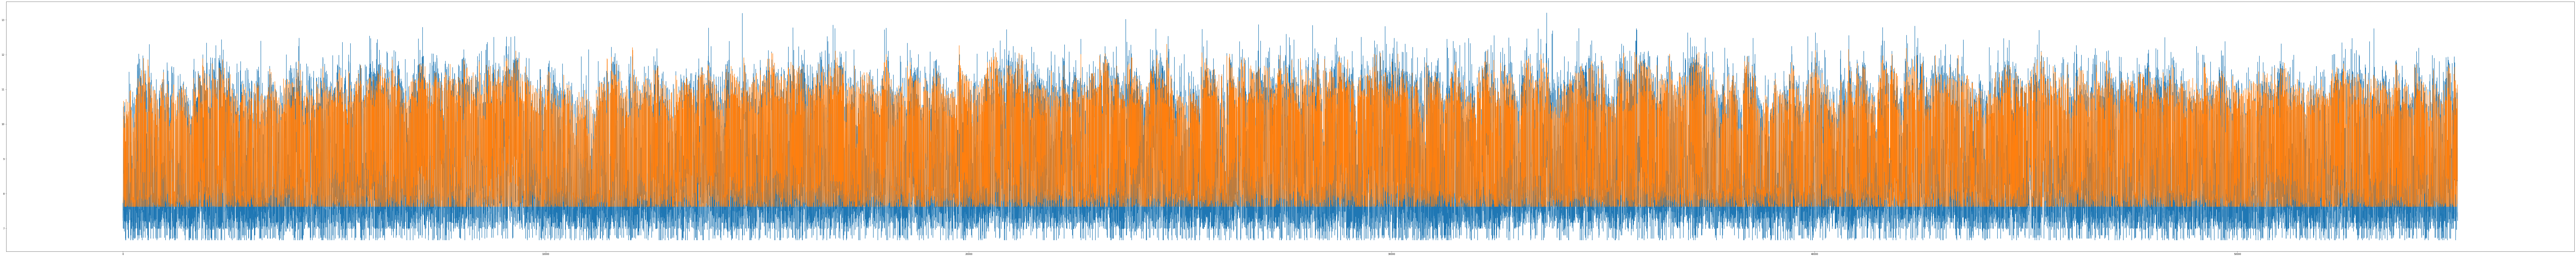

In [17]:
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)

print(X_val_scaled, y_val_log.values, results)
plt.figure(figsize=(200,20))

plt.plot(y_val_log.values)
plt.plot(results)
plt.show()

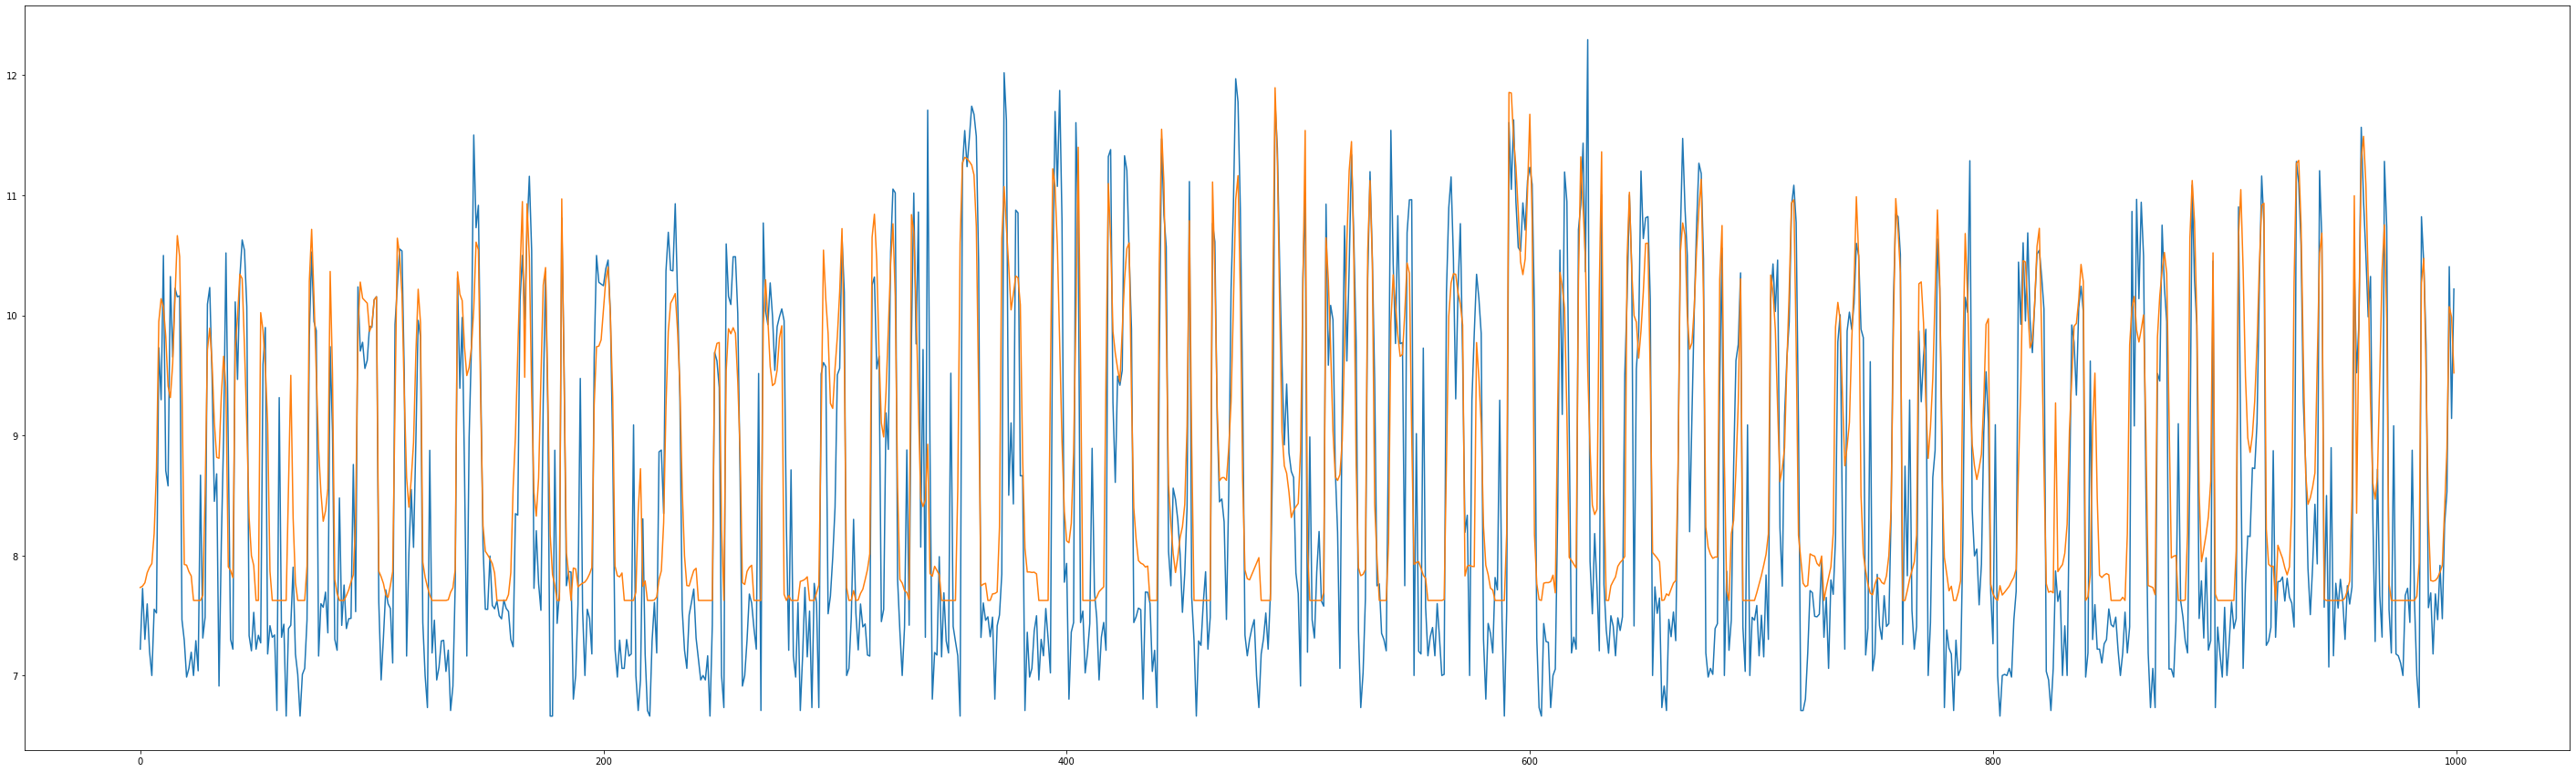

In [18]:
plt.figure(figsize=(50,15))

plt.plot(y_val_log.values[:1000])
plt.plot(results[:1000])
plt.show()

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, MaxPooling1D
from keras.layers.merge import concatenate
#create model
model = Sequential()
modelhist = Sequential()

#add model layers
input1 = Input(shape=(148,1))
input2 = Input(shape=(hist_len,22,1))

model=Dense(int(148), activation='relu')(input1)
model=Dense(int(22), activation='relu')(model)
model = Flatten()(model)

modelhist=Conv2D(22, kernel_size=(int(hist_len),1), activation='relu')(input2)
modelhist=Dense(int(22), activation='relu')(modelhist)

modelhist=Flatten()(modelhist)

merged = concatenate([model,modelhist])

output = Dense(4,activation='relu')(merged)
output = Dense(1)(merged)
merged_model = Model(inputs = [input1,input2], outputs =output )
#compile model using accuracy to measure model performance
merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])



In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print(X.shape,X_train_scaled_hist.shape)
X1=X.reshape((X.shape[0],148,1))
print(X1.shape,X_train_scaled_hist.shape)
X_test1=X_test.reshape((X_test.shape[0],148,1))

X_train_scaled_hist1=X_train_scaled_hist.reshape((X_train_scaled_hist.shape[0],hist_len,22))
X_test_scaled_hist1=X_test_scaled_hist.reshape((X_test_scaled_hist.shape[0],hist_len,22))


from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Input, LSTM, TimeDistributed, MaxPooling1D
from keras.layers.merge import concatenate
#create model
model = Sequential()
modelhist = Sequential()
hist_len=128

#add model layers
input1 = Input(shape=(148,1))
input2 = Input(shape=(hist_len,22))

model=Dense(int(148), activation='relu')(input1)
model=Dense(int(22), activation='relu')(model)
model = Flatten()(model)

modelhist=(Conv1D(22, int(hist_len), activation='relu')(input2))
#modelhist=(MaxPooling1D())(modelhist)
modelhist=TimeDistributed(Flatten())(modelhist)
modelhist=LSTM(22,activation='relu')(modelhist)

merged = concatenate([model,modelhist])

output = Dense(4,activation='relu')(merged)
output = Dense(1)(merged)
merged_model = Model(inputs = [input1,input2], outputs =output )

merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


merged_model.fit([X1,X_train_scaled_hist1], y_train_log, validation_data=([X_test1,X_test_scaled_hist1], y_val_log), epochs=10)


Num GPUs Available:  1
(1838283, 148) (1838283, 128, 22, 1)
(1838283, 148, 1) (1838283, 128, 22, 1)


/home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train on 1838283 samples, validate on 55210 samples
Epoch 1/20
1838283/1838283 [==============================] - 243s 132us/step - loss: 0.7845 - accuracy: 0.0000e+00 - val_loss: 0.9585 - val_accuracy: 0.0000e+00
Epoch 2/20
1838283/1838283 [==============================] - 254s 138us/step - loss: 0.6174 - accuracy: 0.0000e+00 - val_loss: 0.8840 - val_accuracy: 0.0000e+00
Epoch 3/20
1838283/1838283 [==============================] - 255s 139us/step - loss: 0.5850 - accuracy: 0.0000e+00 - val_loss: 0.8685 - val_accuracy: 0.0000e+00
Epoch 4/20
1838283/1838283 [==============================] - 260s 141us/step - loss: 0.5695 - accuracy: 5.4399e-07 - val_loss: 0.8480 - val_accuracy: 0.0000e+00
Epoch 5/20
1838283/1838283 [==============================] - 269s 146us/step - loss: 0.5635 - accuracy: 0.0000e+00 - val_loss: 0.8338 - val_accuracy: 0.0000e+00
Epoch 6/20
 575616/1838283 [========>.....................] - ETA: 2:51 - loss: 0.5551 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Input, LSTM, TimeDistributed, MaxPooling1D
from keras.layers.merge import concatenate
#create model
model = Sequential()
modelhist = Sequential()
hist_len=128

#add model layers
input1 = Input(shape=(148,1))
input2 = Input(shape=(hist_len,22))

model=Dense(int(148), activation='relu')(input1)
model=Dense(int(22), activation='relu')(model)
model = Flatten()(model)

modelhist=(Conv1D(22, int(hist_len/2+1), activation='relu')(input2))
modelhist=(MaxPooling1D())(modelhist)
modelhist=(MaxPooling1D())(modelhist)
modelhist=TimeDistributed(Flatten())(modelhist)
modelhist=LSTM(16,activation='relu')(modelhist)

merged = concatenate([model,modelhist])

output = Dense(4, activation='relu')(merged)
output = Dense(1)(merged)
merged_model = Model(inputs = [input1,input2], outputs =output )
merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [34]:
print(X.shape,X_train_scaled_hist.shape)
X1=X.reshape((X.shape[0],148,1))
print(X1.shape,X_train_scaled_hist.shape)
X_test1=X_test.reshape((X_test.shape[0],148,1))

X_train_scaled_hist1=X_train_scaled_hist.reshape((X_train_scaled_hist.shape[0],hist_len,22))
X_test_scaled_hist1=X_test_scaled_hist.reshape((X_test_scaled_hist.shape[0],hist_len,22))

merged_model.fit([X1,X_train_scaled_hist1], y_train_log, validation_data=([X_test1,X_test_scaled_hist1], y_val_log), epochs=6)

(1838283, 148) (1838283, 128, 22, 1)
(1838283, 148, 1) (1838283, 128, 22, 1)
Train on 1838283 samples, validate on 55210 samples
Epoch 1/6
1838283/1838283 [==============================] - 932s 507us/step - loss: 0.8686 - accuracy: 0.0000e+00 - val_loss: 1.1604 - val_accuracy: 0.0000e+00
Epoch 2/6
1838283/1838283 [==============================] - 921s 501us/step - loss: 0.7807 - accuracy: 0.0000e+00 - val_loss: 1.1334 - val_accuracy: 0.0000e+00
Epoch 3/6
1838283/1838283 [==============================] - 921s 501us/step - loss: 0.7506 - accuracy: 0.0000e+00 - val_loss: 1.0635 - val_accuracy: 0.0000e+00
Epoch 4/6
1838283/1838283 [==============================] - 922s 501us/step - loss: 0.7305 - accuracy: 0.0000e+00 - val_loss: 1.1371 - val_accuracy: 0.0000e+00
Epoch 5/6
1838283/1838283 [==============================] - 921s 501us/step - loss: 0.7114 - accuracy: 0.0000e+00 - val_loss: 1.0470 - val_accuracy: 0.0000e+00
Epoch 6/6
1838283/1838283 [==============================] - 920s 

In [35]:
input1 = Input(shape=(148,1))
input2 = Input(shape=(hist_len,22))

model=Dense(int(148), activation='relu')(input1)
model=Dense(int(22), activation='relu')(model)
model = Flatten()(model)

modelhist=(Conv1D(22, int(hist_len/2+1), activation='relu')(input2))

modelhist=(MaxPooling1D())(modelhist)
modelhist=(Dropout(.2))(modelhist)
modelhist=TimeDistributed(Flatten())(modelhist)
modelhist=LSTM(16,activation='relu')(modelhist)

merged = concatenate([model,modelhist])

output = Dense(4, activation='relu')(merged)
output = Dense(1)(merged)

merged_model = Model(inputs = [input1,input2], outputs =output )
merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

merged_model.fit([X1,X_train_scaled_hist1], y_train_log, validation_data=([X_test1,X_test_scaled_hist1], y_val_log), epochs=6)

Train on 1838283 samples, validate on 55210 samples
Epoch 1/6
1838283/1838283 [==============================] - 1697s 923us/step - loss: 0.8752 - accuracy: 0.0000e+00 - val_loss: 1.1566 - val_accuracy: 0.0000e+00
Epoch 2/6
1838283/1838283 [==============================] - 1773s 964us/step - loss: 0.7877 - accuracy: 0.0000e+00 - val_loss: 1.1884 - val_accuracy: 0.0000e+00
Epoch 3/6
1838283/1838283 [==============================] - 1790s 974us/step - loss: 0.7839 - accuracy: 0.0000e+00 - val_loss: 1.1388 - val_accuracy: 0.0000e+00
Epoch 4/6
1838283/1838283 [==============================] - 1785s 971us/step - loss: 0.7826 - accuracy: 0.0000e+00 - val_loss: 1.1448 - val_accuracy: 0.0000e+00
Epoch 5/6
1838283/1838283 [==============================] - 1785s 971us/step - loss: 0.7818 - accuracy: 0.0000e+00 - val_loss: 1.1534 - val_accuracy: 0.0000e+00
Epoch 6/6
1838283/1838283 [==============================] - 1679s 913us/step - loss: 0.7810 - accuracy: 0.0000e+00 - val_loss: 1.1551 - v

In [86]:
input1 = Input(shape=(148,1))
input2 = Input(shape=(hist_len,22))

model=Dense(int(148), activation='relu')(input1)
model=Dense(int(22), activation='relu')(model)
model=Dropout(.2)(model)
model = Flatten()(model)

modelhist=(Conv1D(32, int(hist_len/2+1), activation='relu')(input2))
modelhist=(MaxPooling1D())(modelhist)                               
modelhist=(Conv1D(32, int(hist_len/8+1), activation='relu')(modelhist))
modelhist=(MaxPooling1D())(modelhist)
modelhist=(Dropout(.2))(modelhist)

modelhist=TimeDistributed(Flatten())(modelhist)
modelhist=LSTM(16,activation='relu')(modelhist)

merged = concatenate([model,modelhist])
output = Dense(4, activation='relu')(merged)
output = Dense(1)(merged)

merged_model = Model(inputs = [input1,input2], outputs =output )
merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
merged_model.summary()
merged_model.fit([X1,X_train_scaled_hist1], y_train_log, validation_data=([X_test1,X_test_scaled_hist1], y_val_log), epochs=6)


Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_140 (InputLayer)          (None, 128, 22)      0                                            
__________________________________________________________________________________________________
conv1d_117 (Conv1D)             (None, 64, 32)       45792       input_140[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_111 (MaxPooling1D (None, 32, 32)       0           conv1d_117[0][0]                 
__________________________________________________________________________________________________
input_139 (InputLayer)          (None, 148, 1)       0                                            
___________________________________________________________________________________________

KeyboardInterrupt: 

In [53]:
input1 = Input(shape=(148,1))
input2 = Input(shape=(hist_len,22))

model=Dense(int(148), activation='relu')(input1)
model = Flatten()(model)

modelhist=(Conv1D(32, int(9), activation='relu')(input2))
modelhist=(MaxPooling1D())(modelhist)                               
modelhist=(Conv1D(32, int(3), activation='relu')(modelhist))
modelhist=(MaxPooling1D())(modelhist)
modelhist=(Dropout(.2))(modelhist)

modelhist=(Flatten())(modelhist)

merged = concatenate([model,modelhist])

output = Dense(128, activation='relu')(merged)
output=Dropout(.2)(output)
output = Dense(32, activation='relu')(output)

output = Dense(1)(output)
merged_model = Model(inputs = [input1,input2], outputs =output )
merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
merged_model.summary()

merged_model.fit([X1,X_train_scaled_hist1], y_train_log, validation_data=([X_test1,X_test_scaled_hist1], y_val_log), epochs=6)


Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           (None, 128, 22)      0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 120, 32)      6368        input_74[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_65 (MaxPooling1D) (None, 60, 32)       0           conv1d_67[0][0]                  
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 58, 32)       3104        max_pooling1d_65[0][0]           
___________________________________________________________________________________________

In [74]:
input1 = Input(shape=(148,1))
input2 = Input(shape=(hist_len,22))

model=Dense(int(148), activation='relu')(input1)
model=Dense(int(22), activation='relu')(model)
model=(Dropout(.2))(model)
model = Flatten()(model)

modelhist=(Conv1D(32, int(9), activation='relu')(input2))
modelhist=(MaxPooling1D())(modelhist)                               
modelhist=(Conv1D(32, int(3), activation='relu')(modelhist))
modelhist=(MaxPooling1D())(modelhist)
modelhist=(Dropout(.2))(modelhist)
modelhist=(Flatten())(modelhist)

merged = concatenate([model,modelhist])
merged=(Flatten())(merged)

merged=LSTM(128,activation='relu')(merged)
output = Dense(32, activation='relu')(merged)
output = Dense(1)(output)

merged_model = Model(inputs = [input1,input2], outputs =output )
#compile model using accuracy to measure model performance
merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
merged_model.summary()
merged_model.fit([X1,X_train_scaled_hist1], y_train_log, validation_data=([X_test1,X_test_scaled_hist1], y_val_log), epochs=6)


ValueError: Input 0 is incompatible with layer flatten_138: expected min_ndim=3, found ndim=2

In [89]:
input1 = Input(shape=(148,1))

model=Dense(int(148), activation='relu')(input1)

merged=TimeDistributed(Flatten())(model)
merged=LSTM(32,activation='relu')(merged)

output = Dense(22, activation='relu')(merged)
output = Dense(1)(output)

merged_model = Model(inputs = input1, outputs =output )
merged_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
merged_model.summary()
merged_model.fit(X1, y_train_log, validation_data=(X_test1, y_val_log), epochs=6)


Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_143 (InputLayer)       (None, 148, 1)            0         
_________________________________________________________________
dense_293 (Dense)            (None, 148, 148)          296       
_________________________________________________________________
time_distributed_71 (TimeDis (None, 148, 148)          0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 32)                23168     
_________________________________________________________________
dense_294 (Dense)            (None, 22)                726       
_________________________________________________________________
dense_295 (Dense)            (None, 1)                 23        
Total params: 24,213
Trainable params: 24,213
Non-trainable params: 0
______________________________________________________

KeyboardInterrupt: 

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers

model.add(Dense(int(148), activation='relu'))
model.add(Dense(22, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.fit(X, np.array(y_train_log), validation_data=(X_test, np.array(y_val_log)), epochs=40)

Train on 1838283 samples, validate on 55210 samples
Epoch 1/40
1838283/1838283 [==============================] - 126s 69us/step - loss: 2.3504 - accuracy: 5.4399e-07 - val_loss: 0.7696 - val_accuracy: 0.0000e+00
Epoch 2/40
1838283/1838283 [==============================] - 133s 73us/step - loss: 0.5273 - accuracy: 0.0000e+00 - val_loss: 0.7579 - val_accuracy: 0.0000e+00
Epoch 3/40
1838283/1838283 [==============================] - 131s 71us/step - loss: 0.4940 - accuracy: 5.4399e-07 - val_loss: 0.7178 - val_accuracy: 0.0000e+00
Epoch 4/40
1838283/1838283 [==============================] - 126s 69us/step - loss: 0.4762 - accuracy: 5.4399e-07 - val_loss: 0.6945 - val_accuracy: 0.0000e+00
Epoch 5/40
1838283/1838283 [==============================] - 126s 69us/step - loss: 0.4670 - accuracy: 5.4399e-07 - val_loss: 0.6906 - val_accuracy: 0.0000e+00
Epoch 6/40
1838283/1838283 [==============================] - 125s 68us/step - loss: 0.4608 - accuracy: 5.4399e-07 - val_loss: 0.6802 - val_acc